## Сравнение `RecursiveCharacterTextSplitter` и `SemanticChunker` с построением графов и поиском по векторной базе

In [ ]:
# установка langchain зависимостей
%pip install langchain langchain-community langchain-text-splitters langchain-huggingface

In [ ]:
# установка остального по
%pip install pypdf unstructured textwrap numpy networkx matplotlib

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from langchain_core.documents import Document
import textwrap

def preview_doc(doc: Document, max_length=100):
  '''Метод для сжатия вывода контента документов.'''
  short_metadata = textwrap.shorten(str(doc.metadata), width=max_length, placeholder='…')
  short_content = textwrap.shorten(doc.page_content, width=max_length, placeholder='…')
  return f"Document(metadata={short_metadata}, page_content='{short_content})'"

### Подготовка данных

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# загружаем PDF файл
loader = PyPDFLoader('https://elib.bsu.by/bitstream/123456789/134709/1/70-74.pdf')
pages = loader.load()
preview_doc(pages[0])

"Document(metadata={'producer': 'Iceni Technology. www.iceni.com', 'creator': '(Infix)', 'creationdate':…, page_content='70 ПСИХОЛОГИЯ СЕМЕЙНЫХ ОТНОШЕНИЙ Роль отца в системе детско-родительских отношений: кризис триангу-…)'"

In [ ]:
from unstructured.cleaners.core import clean

# зачищаем текст от мусора
for page in pages:
  page.page_content = clean(page.page_content, extra_whitespace=True, dashes=True, bullets=True, lowercase=False)

### Стратегия А

Разбиваем на чанки через `RecursiveCharacterTextSplitter`

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# разбиваем PDF на чанки
recursive_chunker = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
recursive_chunks = recursive_chunker.split_documents(pages)

### Стратегия B

Разбиваем на чанки через `SemanticChunker`

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# выбираем модель для создания эмбеддингов
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

embedding_model = HuggingFaceEmbeddings(
  model_name=model_name,
  model_kwargs=model_kwargs,
  encode_kwargs=encode_kwargs
)

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
  embeddings=embedding_model,
  breakpoint_threshold_type='percentile',
  breakpoint_threshold_amount=90,
  min_chunk_size=500
)

semantic_chunks = semantic_chunker.split_documents(pages)

In [ ]:
import numpy as np

def cosine_similarity(X, Y=None):
  if Y is None:
    Y = X

  X = np.array(X)
  Y = np.array(Y)
  X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
  Y_norm = Y / np.linalg.norm(Y, axis=1, keepdims=True)
  return np.dot(X_norm, Y_norm.T)

In [ ]:
from langchain_core.documents import Document
import networkx as nx
from uuid import uuid4

def build_graph(splits: list[Document], threshold) -> nx.Graph:
  # считаем эмбеддинги
  embeddings = embedding_model.embed_documents([doc.page_content for doc in splits])
  # и нумеруем
  embeddings_pack = [(uuid4(), embedding) for embedding in embeddings]

  sim_matrix = cosine_similarity(embeddings)

  # создаём граф
  G = nx.Graph()
  n = len(splits)

  # загоняем чанки как узлы
  for (id, embedding) in embeddings_pack:
    G.add_node(id)

  for i in range(n - 1):
    G.add_edge(i, i + 1, color='blue', weight=2, style='solid')

  # добавляем рёбра, если сходство выше порога
  for i in range(n):
    for j in range(i + 2, n):
      if sim_matrix[i, j] > threshold:
          G.add_edge(i, j, color='red', weight=0.5, style='dashed')

  return G

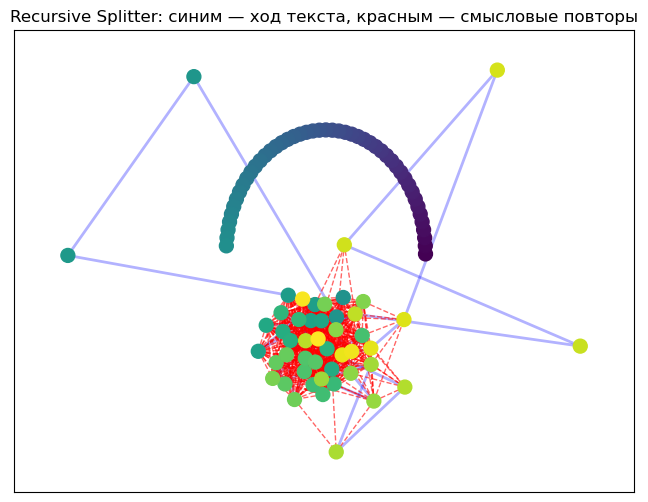

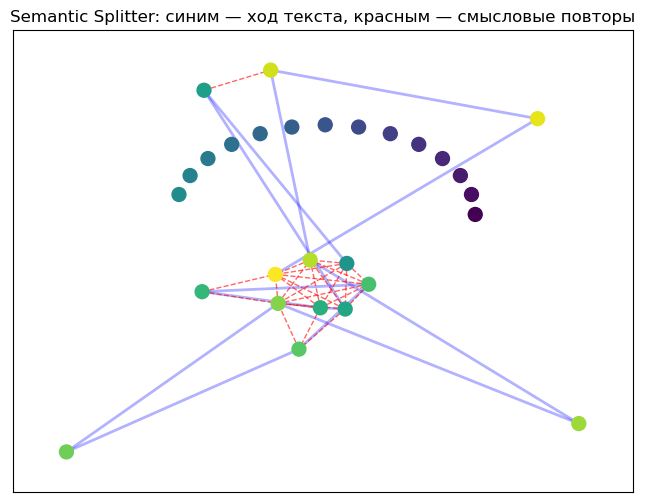

In [ ]:
import matplotlib.pyplot as plt

for name, splits in [("Recursive", recursive_chunks), ("Semantic", semantic_chunks)]:
  G = build_graph(splits, 0.75)
  plt.figure(figsize=(8, 6))

  pos = nx.kamada_kawai_layout(G)

  nx.draw_networkx_nodes(G, pos, node_size=100, node_color=range(len(G)), cmap=plt.cm.viridis)

  # рисуем разные типы ребер
  edges = G.edges(data=True)

  # поток повествования (cиний)
  seq_edges = [(u, v) for u, v, d in edges if d['color'] == 'blue']
  nx.draw_networkx_edges(G, pos, edgelist=seq_edges, edge_color='blue', alpha=0.3, width=2)

  # смысловые прыжки (красный)
  sem_edges = [(u, v) for u, v, d in edges if d['color'] == 'red']
  nx.draw_networkx_edges(G, pos, edgelist=sem_edges, edge_color='red', alpha=0.6, style='dashed')

  plt.title(f"{name} Splitter: синим — ход текста, красным — смысловые повторы")

plt.show()

In [ ]:
from langchain_chroma import Chroma
import textwrap

def test_retrieval(chunks, collection_name, question):
  vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    collection_name=collection_name
  )

  retriever = vectorstore.as_retriever(search_kwargs={'k': 2})
  results = retriever.invoke(question)

  vectorstore.delete_collection()

  return results

query = 'Кризис триангуляции'

print(f'--- Вопрос: {query} ---\n')

print(f'📊 Recursive Chunks (Всего: {len(recursive_chunks)})')
rec_res = test_retrieval(recursive_chunks, "collection_recursive", query)
for doc in rec_res:
    print(f'- {textwrap.shorten(doc.page_content, width=120, placeholder='…')}')

print(f'\n📊 Semantic Chunks (Всего: {len(semantic_chunks)})')
sem_res = test_retrieval(semantic_chunks, "collection_semantic", query)
for doc in sem_res:
    print(f'- {textwrap.shorten(doc.page_content, width=120, placeholder='…')}')

--- Вопрос: Кризис триангуляции ---

📊 Recursive Chunks (Всего: 48)
- 70 ПСИХОЛОГИЯ СЕМЕЙНЫХ ОТНОШЕНИЙ Роль отца в системе детско родительских отношений: кризис триангу ляции Дисциплинарные…
- 55 лет, показали, что у мужчин в среднем выражена тенденция идентифициро ваться больше с отцом, чем с матерью. В случае…

📊 Semantic Chunks (Всего: 14)
- Отношения с отцом делают возможным становление объек тивного восприятия действительности. Согласно Д. Винникотту ,…
- В исследовании приняли участие дети 6—11 лет, воспитывающие ся родными родителями, в количестве 60 человек, из них 31…


<img src="https://media1.tenor.com/m/GvNvPh7yAcwAAAAC/arknights-lappland.gif" width="300" height="150" />